In [1]:
%load_ext autoreload
%autoreload 2

# Load Dependencies

In [2]:
import matplotlib.pyplot as plt

import torch

import pyro
import numpy as np
import pyro.distributions as dist
# from pyro.poutine import trace, replay, block
# from pyro.infer.autoguide.guides import AutoDelta, AutoNormal
# from pyro.infer import SVI, Trace_ELBO, Predictive

from pyciemss.ODE.askem_primitives import sample, infer_parameters, intervene, optimization

# import sys
# sys.path.append("../")

#
from pyciemss.utils import get_tspan

import warnings
warnings.filterwarnings('ignore')

/Users/zuck016/.pyenv/versions/jz-scenario2-eval/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plotting Utilities

In [3]:
def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time /days')
    ax.set_ylabel('Infected (1000s)')
    return ax

def plot_predictive(prediction, tspan, tmin=None, ax=None, alpha=0.2, color="black", **kwargs):
    vars = ["I_total_obs"]
    #infection_total = sum([prediction[x].squeeze().detach().numpy()/1000. for x in ['I_obs', 'D_obs', 'A_obs', 'R_obs', 'T_obs']])

    I_low = torch.quantile(prediction["I_total_obs"], 0.05, dim=0).detach().numpy()
    I_up = torch.quantile(prediction["I_total_obs"], 0.95, dim=0).detach().numpy()

    if tmin:
        indeces = tspan >= tmin
    else:
        indeces = torch.ones_like(tspan).bool()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    
    ax.fill_between(tspan[indeces], I_low[indeces], I_up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

def plot_trajectory(data, tspan, ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None, observation='I_total_obs'):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    #infection_total = sum([data[x].squeeze().detach().numpy()/1000. for x in ['I_obs', 'D_obs', 'A_obs', 'R_obs', 'T_obs']])
    ax.plot(tspan, data[observation].squeeze().detach().numpy(), color, alpha=alpha, lw=lw, marker=marker, label=label)
    
    return ax

def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='-')

    return ax

# Setup Parameters

In [4]:
full_tspan = get_tspan(1, 100, 100)

num_samples = 500

# Total population, N.
N = 1
# Initial number of infected and recovered individuals, I0 and R0.
I0, D0, A0, R0, T0, H0, E0 = 200./60e6, 20./60e6, 1./60e6, 2./60e6, 0, 0, 0

# Everyone else, S0, is susceptible to infection initially.

S0 = N - I0 - D0 - A0 - R0 - T0 - H0 - E0


#I_obs = torch.tensor([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])

initial_state = tuple(torch.as_tensor(s) for s in  (S0, I0, D0, A0, R0, T0, H0, E0))
final_observed_state = tuple(torch.as_tensor(s) for s in  (S0, I0, D0, A0, R0, T0, H0, E0))

# Probabilistic Forecasting - Passing unit test 1
There are two ‘unit tests’ we want to pass, to ensure that we understood and can reproduce the published model:

## 1.a Unit Test \#1:

Set the initial values and parameters, as described in the Supplementary Methods section of the publication (pg. 9 of the pdf): 

1. Initial Values: 
* $I = 200/60e6$,
* $D = 20/60e6$, 
* $A = 1/60e6$, 
* $R = 2/60e6$, 
* $T = 0$, 
* $H = 0$, 
* $E = 0$; 
* $S = 1 – I – D – A – R – T – H – E$. 

Let total population = 60e6.
Parameters: $$\alpha = 0.570, \beta = \delta  = 0.011, \gamma = 0.456, \epsilon = 0.171, \theta = 0.371, \zeta = \eta = 0.125, \mu = 0.017, \nu = 0.027, \tau = 0.01, \lambda = \rho = 0.034$$ and $$\kappa = \xi = \sigma = 0.017$$.

from pyciemss.ODE.models import SIDARTHE

pyro.set_rng_seed(0)

ode_model = SIDARTHE(N=1,
                 alpha_prior=dist.Delta(torch.tensor (0.570)) ,
                 beta_prior=dist.Delta(torch.tensor (0.011)) ,
                 gamma_prior=dist.Delta(torch.tensor (0.456)) ,
                 delta_prior=dist.Delta(torch.tensor (0.011)) ,
                 epsilon_prior=dist.Delta(torch.tensor (0.171)) ,
                 lamb_prior =dist.Delta(torch.tensor (0.034)) ,
                 zeta_prior=dist.Delta(torch.tensor (0.125)) ,
                 eta_prior=dist.Delta(torch.tensor (0.125)) ,
                 kappa_prior=dist.Delta(torch.tensor (0.017)) ,
                 theta_prior=dist.Delta(torch.tensor (0.371)) ,
                 rho_prior=dist.Delta(torch.tensor (0.034)) ,
                 xi_prior=dist.Delta(torch.tensor (0.017)) ,
                 sigma_prior=dist.Delta(torch.tensor (0.017)) ,
                 mu_prior=dist.Delta(torch.tensor (0.017)) ,
                 nu_prior=dist.Delta(torch.tensor (0.027)) ,
                 tau_prior=dist.Delta(torch.tensor (0.01)) )

In [17]:
from pyciemss.ODE.models import MIRA_SIDARTHE
from pathlib import Path
import os
MODELPATH = '../../test/models/evaluation_examples/scenario_2/'
SIDARTHEPATH = 'scenario2_sidarthe_v.json'
plotting_ode_model = MIRA_SIDARTHE.from_mira(os.path.join(MODELPATH,SIDARTHEPATH))
param2transition = {
    trans.rate.key: trans
    for trans in plotting_ode_model.G.transitions.values()
}
for param in param2transition:
    print(param, param2transition[param].rate.value)

beta 0.011
gamma 0.456
delta 0.011
alpha 0.57
epsilon 0.171
zeta 0.125
lambda 0.034
eta 0.125
rho 0.034
theta 0.371
kappa 0.017
mu 0.017
nu 0.027
xi 0.017
tau_2 1.0
sigma 0.017
phi 1.0
tau_1 1.0


In [18]:
from pyciemss.ODE.models import MIRA_SIDARTHE
from pathlib import Path
import os
MODELPATH = '../../test/models/evaluation_examples/scenario_2/'
SIDARTHEPATH = 'scenario2_sidarthe_v.json'
plotting_ode_model = MIRA_SIDARTHE.from_mira(os.path.join(MODELPATH,SIDARTHEPATH))
param2transition = {
    trans.rate.key: trans
    for trans in plotting_ode_model.G.transitions.values()
}
for param in param2transition:
    print(param, param2transition[param].rate.value)

beta 0.011
gamma 0.456
delta 0.011
alpha 0.57
epsilon 0.171
zeta 0.125
lambda 0.034
eta 0.125
rho 0.034
theta 0.371
kappa 0.017
mu 0.017
nu 0.027
xi 0.017
tau_2 0.01
sigma 0.017
phi 0.0
tau_1 0.00333


Note that $\phi = \tau_1 = \tau_2 = 1$.   We could fix this in programmatically, but for expediencey we manually fix the json

In [19]:
plotting_ode_model.param_prior

<bound method PetriNetODESystem.param_prior of MIRA_SIDARTHE()>

In [20]:
#initial_state = tuple(torch.as_tensor(s) for s in  ( A0, D0, E0, H0, I0, R0, S0, T0, V0))
initial_state = tuple(torch.as_tensor(v.data['initial_value'])
                      if v.data['initial_value'] is not None else torch.as_tensor(0.)
                      for v in plotting_ode_model.var_order.values())
initial_state

(tensor(1.6667e-08),
 tensor(3.3333e-07),
 tensor(0.),
 tensor(0.),
 tensor(3.3333e-06),
 tensor(3.3333e-08),
 tensor(1.0000),
 tensor(0.),
 tensor(0.))

In [21]:
#prior_prediction = sample(plotting_ode_model, num_samples, initial_state, full_tspan)
single_prediction = sample(plotting_ode_model, 1, initial_state, full_tspan)

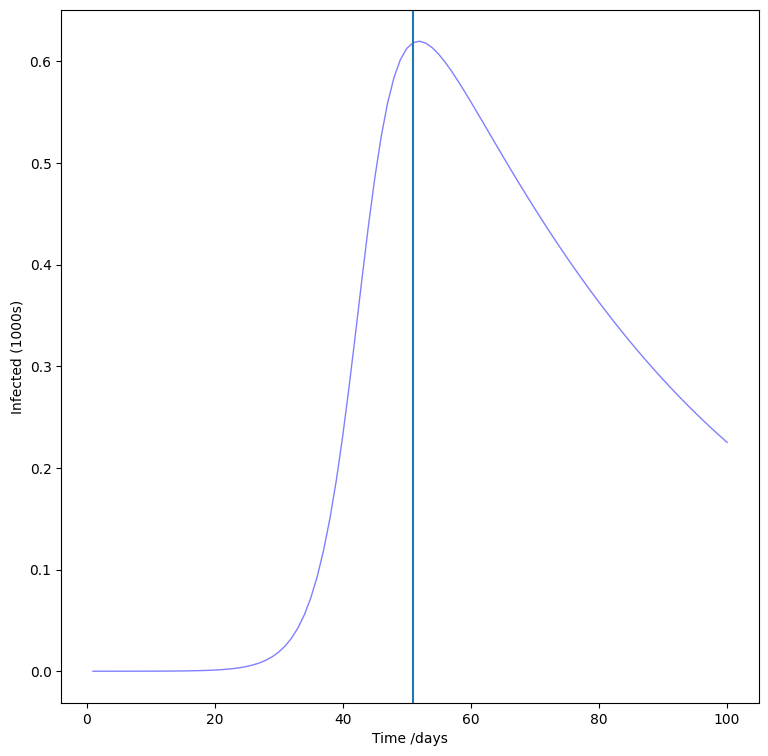

In [22]:
ax = plot_trajectory(single_prediction, full_tspan, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast",
                    observation='obs_total_infections')
#ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")
ax.axvline(51)


Simulate for $100$ days, and determine the day and level of peak total infections (sum over all the infected states $I, D, A, R, T$). Expected output: The peak should occur around day $47$, when $\sim 60\%$ of the population is infected.

In [24]:
single_prediction


'zeta'

## 1.b Unit Test \#2: 

Now update the parameters to reflect various interventions that Italy implemented during the first wave, as described in detail on pg. 9.  Simulate for 100 days, reproduce the trajectories in Fig. 2B, and determine the day and level of peak total infections (sum over all the infected states I, D, A, R, T). Expected output: Trajectories in Fig. 2B, peak occurs around day 50, with ~0.2% of the total population infected.

### Day 4 social distancing
After day 4, as a consequence of basic social-distancing measures due to the public being aware of the epidemic outbreak and due to recommendations (such  as washing hands often, not touching one’s face, avoiding handshakes and keeping  distance) and early measures (such as closing schools) by the Italian government,  we set $\alpha= 0.422, \beta = \delta = 0.0057$  and $\gamma = 0.285$, so the new basic reproduction number becomes $R_0 = 1.66$.

### Day 12 screening limited to symptomatic individuals
Also, after day 12, we set $\epsilon  = 0.143$ as a consequence of the policy limiting screening to symptomatic individuals only; thus, totally asymptomatic individuals  are almost no longer detected, while individuals with very mild symptoms are still  detected (hence $\epsilon$ is not set exactly to zero). Due to this, $R_0 = 1.80$. 

In [19]:

plotting_ode_model = pyro.do(ode_model, {"noise_var": torch.tensor([0.000001])})

### Day 22 incomplete lockdown
After day 22, the lockdown, at first incomplete, yields $\alpha  = 0.360,  \beta = \delta = 0.005$  and $\gamma = 0.200$;  also, $\zeta = \eta = 0.034, \mu = 0.008, \nu = 0.015, \lambda = 0.08$  and  $\rho= \kappa = \xi = \sigma = 0.017$. Hence, the new basic reproduction number becomes $R_0 = 1.60$. 

### Day 28 fully operational lockdown
After day 28, the lockdown is fully operational and gets stricter (working is no longer a good reason for going out: gradually, non-indispensable activities are  stopped): we get $\alpha  = 0.210$ and $\gamma = 
0.110$,  hence $R_0 = 0.99$. 

### Day 38 wider testing campaign launched
After day 38, a wider testing campaign is launched: this yields $\epsilon  = 0.200$,  and also $\rho  = \kappa = \xi = 0.020$,  while $\sigma = 0.010$  and $\zeta = \eta = 0.025$.  Therefore, $R_0 = 0.85$.

In [15]:
from pyciemss.ODE.models import SIDARTHE

pyro.set_rng_seed(0)

ode_model = SIDARTHE(N=1,
                 alpha_prior=dist.LogNormal(torch.log(torch.tensor (0.570)), torch.tensor(0.5)) ,
                 beta_prior=dist.LogNormal(torch.log(torch.tensor (0.011)), torch.tensor(0.5)) ,
                 gamma_prior=dist.LogNormal(torch.log(torch.tensor (0.456)), torch.tensor(0.5)) ,
                 delta_prior=dist.LogNormal(torch.log(torch.tensor (0.011)), torch.tensor(0.5)) ,
                 epsilon_prior=dist.LogNormal(torch.log(torch.tensor (0.171)), torch.tensor(0.5)) ,
                 lamb_prior =dist.LogNormal(torch.log(torch.tensor (0.034)), torch.tensor(0.5)) ,
                 zeta_prior=dist.LogNormal(torch.log(torch.tensor (0.125)), torch.tensor(0.5)) ,
                 eta_prior=dist.LogNormal(torch.log(torch.tensor (0.125)), torch.tensor(0.5)) ,
                 kappa_prior=dist.LogNormal(torch.log(torch.tensor (0.017)), torch.tensor(0.5)) ,
                 theta_prior=dist.LogNormal(torch.log(torch.tensor (0.371)), torch.tensor(0.5)) ,
                 rho_prior=dist.LogNormal(torch.log(torch.tensor (0.034)), torch.tensor(0.5)) ,
                 xi_prior=dist.LogNormal(torch.log(torch.tensor (0.017)), torch.tensor(0.5)) ,
                 sigma_prior=dist.LogNormal(torch.log(torch.tensor (0.017)), torch.tensor(0.5)) ,
                 mu_prior=dist.LogNormal(torch.log(torch.tensor (0.017)), torch.tensor(0.5)) ,
                 nu_prior=dist.LogNormal(torch.log(torch.tensor (0.027)), torch.tensor(0.5)) ,
                 tau_prior=dist.LogNormal(torch.log(torch.tensor (0.01)), torch.tensor(0.5)) )

## 1.c Sensitivity analysis

## 1.d Policies that prevent infections from exceeding 1/3 of the population

Now return to the situation in b.i (constant parameters that don’t change over time). Let’s say we want to increase testing, diagnostics, and contact tracing efforts (implemented by increasing the detection parameters  and ). Assume that $\theta \ge 2\epsilon$ , because a symptomatic person is more likely to be tested. What minimum constant values do these parameters need to be over the course of a 100-day simulation, to ensure that the total infected population (sum over all the infected states I, D, A, R, T) never rises above 1/3 of the total population?




### Problem Formulation
* **Quantity of interest**:  Total infections out of $N=60,000,000$ population
$$I_{total}(t; \mathbf{u}, \mathbf{Z}) = I(t) + D(t) + A(t) + R(t) + T(t)$$

A conservative estimate for the quantity of interest is
$$M(u, Z) = \max_{1\leq t \leq 100} I_{total}(t; \mathbf{u}, \mathbf{Z})/N$$




* **Control**: $\mathbf{u}\in \mathcal{U} \subseteq \mathbb{R}^{n_u}$
    * Detection parameter for Infected ($\epsilon$) assuming that $\theta=2\epsilon$
    * Two detection parameters $\theta, \epsilon$, constraining $\theta \ge 2\epsilon$.
    


* **Risk-based optimization under uncertainty problem formulation**
    * Objective Function - Minimize the magnitude of the parameter interventions.
    * Constraint - Risk of normalized total infections exceeding the prescribed threshold of $1/3$, $\mathcal{R}( M(\mathbf{u},\mathbf{Z}))$, is below the acceptable risk threshold, $\mathcal{R}_\text{threshold}$.

\begin{equation} 
\begin{split} 
\mathbf{u}^*= \underset{\mathbf{u}\in\mathcal{U}}{\arg\min}\ & \lVert \mathbf{u} \rVert_1 \\ \text{s.t.}\ & \mathcal{R}( M(\mathbf{u}, \theta)) \le \mathcal{R}_\text{threshold} 
\end{split} 
\end{equation}

#### Formulation 1: Optimize $\epsilon$ only, assuming $\epsilon = \theta$
\begin{equation} 
\begin{split} 
\epsilon^*= \underset{\epsilon\in\mathcal{U}}{\arg\min}\ & \epsilon \\ \text{s.t.}\ & \mathbb{P}( M(\epsilon, \mathbf{Z}) \ge 1/3) \le 0.05
\end{split} 
\end{equation}

#### Formulation 2: Optimize $\epsilon$ and $\theta$ constraining $\theta \ge 2\epsilon$
\begin{equation} 
\begin{split} 
\epsilon^\ast, \theta^\ast= \underset{\{\epsilon,\theta\}\in\mathcal{U}}{\arg\min}\ & \theta + \epsilon \\ \text{s.t.}\ & \mathbb{P}( M(\epsilon,\theta, \mathbf{Z}) \ge 1/3) \le 0.05, \\
& \theta \ge 2\epsilon
\end{split} 
\end{equation}

Apart from probability of exceedance, we will explore quantiles and superquantiles as risk measures.

# 2. SIDARTHE-V

Next, we want to explore the updated model SIDARTHE-V, which is found at https://doi.org/10.1038/s41591-021-01334-5, pdf: https://www.nature.com/articles/s41591-021-01334-5  

Do a structural model comparison of the original SIDARTHE and SIDARTHE-V. The structural comparison work product should include a summary or diagram describing similarities and differences between the models, with respect to parameters, variables/states, pathways, etc.

Set the same initial values and parameter settings in 1.b.i. Let $V(t=0) = 0$, $\tau$ (in `SIDARTHE`) = $\tau_2$ (in `SIDDARTHE-V`), and $\tau_1 = (1/3)*\tau_2$ (reflecting the fact that the mortality rate for critical conditions (state $T$), will always be larger than for other infected states). Assume that the vaccination rate $\psi$ is $0$ to start with. The `SIDARTHE-V` model allows for three main types of interventions: 

1. Those that impact the transmission parameters ($\alpha, \beta, \gamma$ and $\delta$ ) – social distancing, masking, lockdown; 
2. Those that impact the detection parameters $(\epsilon, \theta )$ – testing and contact tracing; 
3. Those that impact the vaccination rate $\psi$ – vaccination campaigns. Assume previously stated constraints: $\theta >= 2\epsilon$ , and $\tau_1 = (1/3)*\tau_2$.

Let’s say our goal is to ensure that the total infected population (sum over all the infected states $I, D, A, R, T$) never rises above $1/3$ of the total population, over the course of the next $100$ days. If you could choose only a single intervention (affecting only one parameter), which intervention would let us meet our goal, with minimal change to the intervention parameter? Assume that the intervention will be implemented after one month ($t =$ day $30$), and will stay constant after that, over the remaining time period (i.e. the following $70$ days). What are equivalent interventions of the other two intervention types, that would have the same impact on total infections?
Let’s say our goal is to get the reproduction number $R_0$ below $1.0$, at some point within the next $100$ days. 

* Are there interventions that will allow us to meet our goal? 

If there are multiple options, which single intervention would have the greatest impact on $R_0$ and let us meet our goal with minimal change to the intervention parameter? Assume that the intervention will be implemented after one month ($t =$ day $30$), and will stay constant after that, over the remaining time period (i.e. the following $70$ days).

In [ ]:

# from causal_pyro.query.do_messenger import do
from pyciemss.ODE.interventions import constant_intervention_builder, time_dependent_intervention_builder, state_dependent_intervention_builder, parameter_intervention_builder


## Q: "What would happen if we set the vaccination rate parameter, $\nu$?"


In [ ]:
pyro.set_rng_seed(0)

rate_parameter_intervention = parameter_intervention_builder("nu", torch.tensor([0.01]))
# intervened_parameter_model = do(plotting_ode_model, rate_parameter_intervention)
plotting_intervened_parameter_model = intervene(plotting_ode_model, rate_parameter_intervention)
# intervened_parameter_prediction = Predictive(intervened_parameter_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
intervened_parameter_prediction = sample(plotting_intervened_parameter_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)


In [ ]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, new_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "We can't change the rate parameter directly. Bring me another policy!"
## Q: "What would happen if we set the vaccination rate to a constant 500 people per day?"

In [ ]:
pyro.set_rng_seed(0)

flux_intervention = constant_intervention_builder("SV_flux", torch.tensor([500.])), full_tspan)
# intervened_flux_model = do(ode_model, flux_intervention)
plotting_intervened_flux_model = intervene(plotting_ode_model, flux_intervention)
# intervened_flux_prediction = Predictive(plotting_intervened_flux, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
rate_intervention_prediction = sample(plotting_intervened_flux_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)

In [ ]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(rate_intervention_prediction, new_tspan, ax=ax, color='blue', label="Vaccination Rate Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "We have a lot more vaccines than that, but they aren't available yet!"
## Q: "What would happen if we set the vaccination rate to 500 people per day for the first month, then 750, then 1000?"


In [ ]:
pyro.set_rng_seed(0)

def ramping_rate_up_intervention_function(t):
    month = torch.floor(t / 30.).int()
    return torch.tensor([500.0, 750.0, 1000.])[month]

ramping_rate_up_intervention = time_dependent_intervention_builder("SV_flux", ramping_rate_up_intervention_function, new_tspan)
# ramping_rate_up_intervention_model = do(plotting_ode_model, ramping_rate_up_intervention)
plotting_ramping_rate_up_intervention_model = intervene(plotting_ode_model, ramping_rate_up_intervention)
# ramping_rate_up_intervention_prediction = Predictive(plotting_ramping_rate_up_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
ramping_intervention_prediction = sample(plotting_ramping_rate_up_intervention_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)


In [ ]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(ramping_intervention_prediction, new_tspan, ax=ax, color='green', label="Ramping Up Vaccination Rate Intervention")
ax = plot_intervention_line(7., ax=ax)


## Governor: "We can't force people to take a vaccine. Let's run a marketing campaign to encourage vaccination!"
## Q: "What would happen if the marketing campaign convinces 500 **more** people per day to get vaccinated than without it?"


In [ ]:
pyro.set_rng_seed(0)

def vaccination_encouragement_intervention_function(SV_flux):
    return SV_flux + torch.tensor([500.])

vaccination_encouragement_intervention = state_dependent_intervention_builder("SV_flux", vaccination_encouragement_intervention_function, new_tspan)
# plotting_vaccination_encouragement_intervention_model = do(ode_model, vaccination_encouragement_intervention)
plotting_vaccination_encouragement_intervention_model = intervene(plotting_ode_model, vaccination_encouragement_intervention)
# vaccination_encouragement_intervention_prediction = Predictive(vaccination_encouragement_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
vaccination_encouragement_intervention_prediction = sample(plotting_vaccination_encouragement_intervention_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)


In [ ]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, color='black', label="No Intervention")
ax = plot_predictive(vaccination_encouragement_intervention_prediction, new_tspan, ax=ax, color='purple', label="Vaccination Encouragement Intervention")
ax = plot_intervention_line(7., ax=ax)


In [ ]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, color='black', ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, new_tspan, hatch='.', edgecolor="red", linewidth=2.5, facecolor="none", ax=ax, alpha=0.3, label="Vaccination Rate Parameter Intervention")
ax = plot_predictive(rate_intervention_prediction, new_tspan, hatch='/', ax=ax, alpha=0.3, linewidth=2.5, edgecolor='blue', facecolor="none", label="Vaccination Rate Intervention")
ax = plot_predictive(ramping_intervention_prediction, new_tspan, hatch='..', linewidth=3, ax=ax, alpha=0.3, edgecolor='green', facecolor="none", label="Ramping Up Vaccination Rate Intervention")
ax = plot_predictive(vaccination_encouragement_intervention_prediction, new_tspan, hatch="\\", linewidth=2.5, ax=ax, alpha=0.3, edgecolor='black', facecolor="none", label="Vaccination Encouragement Intervention")
ax = plot_intervention_line(7., ax=ax)


## Governor: "Let's only market to young people!"
## Q: "What would happen if the marketing campaign convinces 500 more people age 18-24 per day to get vaccinated than without it?"


In [ ]:

pyro.set_rng_seed(0)

stratified_intervention = state_dependent_intervention_builder("SV_flux_18-24", vaccination_encouragement_intervention_function, new_tspan)
# stratified_intervention_model = do(ode_model, stratified_intervention)
stratified_intervention_model = intervene(ode_model, stratified_intervention)


In [ ]:

import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    value.__cause__ = None  # suppress chained exceptions
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

raise ValueError("The Intervention Variable SV_flux_18-24 is not defined and can not be intervened on. To fix this error, revise the model to include SV_flux_18-24").with_traceback(None) from None

# Risk-based optimization under uncertainty
## Q: "What is the minimal vaccination policy that results in less than 150 infected individuals after 90 days?"

### Problem Formulation
* **Quantity of interest**: 7-day average of total infections after 90 days
    $$M(\mathbf{u}, \theta) = \frac{1}{7}\sum_{i=0}^6 I(t=90-i;\mathbf{u},\theta)+I_\text{V}(t=90-i;\mathbf{u},\theta)$$

* **Control**: $\mathbf{u}\in \mathcal{U} \subseteq \mathbb{R}^{n_u}$
    * Vaccination rate parameter: $u=\nu$
    * Scheduled intervention changing SV_flux over each month: $\mathbf{u} \in \mathbb{R}^3$
    * Other practical policies as interventions



* **Risk-based optimization under uncertainty problem formulation**
    * Objective Function - Minimize the vaccination rate.
    * Constraint - Risk of infections exceeding the prescribed threshold of 10, $\mathcal{R}( M(\mathbf{u}, \theta))$, is below the acceptable risk threshold, $\mathcal{R}_\text{threshold}$.

\begin{equation} 
\begin{split} 
\mathbf{u}^*= \underset{\mathbf{u}\in\mathcal{U}}{\arg\min}\ & \lVert \mathbf{u} \rVert_1 \\ \text{s.t.}\ & \mathcal{R}( M(\mathbf{u}, \theta)) \le \mathcal{R}_\text{threshold} 
\end{split} 
\end{equation}

## Comparing risk measures

![table_risk.png](figures/table_risk.png)

#### Adavantages of using alpha-superquantile
* Considers magnitude of infections exceeding the threshold:
    * Overcome limitations of hard thresholding
    * Desirable data-informed conservativeness
* Preserves properties of underlying quantities of interest, such as convexity

In [ ]:
import os
import time
import pickle

import sys
sys.path.append("../")

import numpy as np
from scipy import stats
from matplotlib import ticker

from pyciemss.ODE.models import SVIIvR
from pyciemss.ODE.interventions import constant_intervention_builder

from pyciemss.risk.risk_measures import alpha_quantile, alpha_superquantile
from pyciemss.risk.ouu import computeRisk
from pyciemss.risk.qoi import nday_rolling_average

# Plotting helpers
def sideaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

def sideaxishist(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # For y-axis
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.tick_params(axis='x', labelsize=12)  # change fontsize for x-axis tick labels
    # ax.xaxis.major.formatter._useMathText = True
    return


co = ['#377eb8', '#ff7f00', '#984ea3', '#ffd92f', '#a65628']
rlabel = ['Q_alpha-based OUU', 'barQ_alpha-based OUU']

## Exploring the difference between Quantiles and Super-Quantiles

In [ ]:
torch.manual_seed(1)

POLICY = np.array([100.])
N_SAMPLES = 1000

RISK = computeRisk(model=ode_model,
                 intervention_fun=lambda x: constant_intervention_builder("SV_flux", torch.from_numpy(x)), new_tspan)),
                 qoi=lambda y: nday_rolling_average(y, contexts=["I_obs"])),
                 risk_measure=alpha_superquantile,
                 num_samples=N_SAMPLES,
                 model_state=final_observed_state,
                 tspan=new_tspan,
                 guide=guide
                )

start_time = time.time()
sq_dataCube = RISK.propagate_uncertainty(POLICY)
end_time = time.time()
forward_time = end_time - start_time
time_per_eval = forward_time / N_SAMPLES
print(f"Forward UQ took {forward_time:.2f} seconds total ({forward_time/N_SAMPLES:.2e} seconds per model evaluation).")
sq_qoi = RISK.qoi(sq_dataCube)
sq_sv = RISK.risk_measure(sq_qoi)

RISK.risk_measure = alpha_quantile
q_sv = RISK(POLICY)

In [ ]:
bins_hist = 50
fig1 = plt.figure()
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(sq_qoi, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections')
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(q_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-quantile', color=co[0])
cax.vlines(sq_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', size=20)
cax.legend(loc='upper right', prop={'size': 20})
plt.show()

## Risk-based optimization under uncertainty with intervention on vaccination rate parameter $\nu$
**NOTE:** This is a demonstration of the interface, optimization is not run to convergence nor are enough samples generated to accurately estimate the risk, so take the results with a grain of salt.

In [ ]:
from pyciemss.risk.ouu import RandomDisplacementBounds, computeRisk, solveOUU
from pyciemss.risk.qoi import nday_rolling_average
from pyciemss.risk.risk_measures import alpha_superquantile, alpha_quantile
import scipy

# Define problem specifics.
RISK_BOUND = 250.
X_MIN = 0.
X_MAX = 0.95

N_SAMPLES = int(5e2)
MAXITER = 10
TOL = 1e-5

RISK_ALPHA = 0.9

# Control action / intervention.
INIT_ITERATE = 0.75
INTERVENTION = lambda x: constant_intervention_builder("nu", x, new_tspan)

# Objective function.
OBJFUN = lambda x: x  # minimize the scalar value itself.

# Define the risk measure.
VAX_RISK = computeRisk(
                        model=noisy_ode_model,
                        intervention_fun=INTERVENTION,
                        qoi=lambda y: nday_rolling_average(y, contexts=["I_obs"])),
                        model_state=final_observed_state,
                        tspan=new_tspan,
                        risk_measure=lambda z: alpha_superquantile(z, alpha=RISK_ALPHA)),
                        num_samples=N_SAMPLES,
                        guide=guide,
                        )

# Define problem constraints.
CONSTRAINTS = (
                # risk constraint
                {'type': 'ineq', 'fun': lambda x: RISK_BOUND - VAX_RISK(x)},

                # bounds on control
                # NOTE: perhaps use scipy.optimize.LinearConstraint in the future
                {'type': 'ineq', 'fun': lambda x: x - X_MIN},
                {'type': 'ineq', 'fun': lambda x: X_MAX - x}
               )

In [ ]:
# Go do the dang thing.
print("Performing risk-based optimization under uncertainty ...")
print(f"Estimated wait time {time_per_eval*N_SAMPLES*MAXITER:.0f} seconds.")
sq_result = solveOUU(
                     x0=INIT_ITERATE,
                     objfun=OBJFUN,
                     constraints=CONSTRAINTS,
                     optimizer_algorithm="COBYLA",
                     tol=TOL,
                     options={
                         "disp": False,
                         "maxiter": MAXITER
                             },
                    ).solve()
print(f"Optimizer finished. Optimal Vaccination rate is:\t{sq_result.x[0]:.4}")
est_risk = VAX_RISK(sq_result.x[0])
print(f"Estimated risk was:\t{est_risk:.2f}")

## Assess the effect of the control policy.

In [ ]:
intervened_prediction = VAX_RISK.propagate_uncertainty(POLICY)
qois = VAX_RISK.qoi(intervened_prediction)

In [ ]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_prediction, new_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)


In [ ]:
bins_hist = 50
fig1 = plt.figure()
# plt.rc('text')
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(qois, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections (intervened)', density=True)
cax.hist(VAX_RISK.qoi(posterior_prediction)), color=co[4], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='do nothing', density=True)
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(est_risk, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', size=20)
cax.legend(loc='upper right', prop={'size': 20})
plt.show()